In [ ]:
## Update Pan-Dataset Values for W25

In [ ]:
## I like the more continuous & orthogonal values we get out of running sparse PCA

## but I don't like how arbitrary it is *and the requirement to feed it complete datasets* (part with very crude mean imputation!)

## I don't think there's a good rationale for weighting different waves differently
# at least not for the reason of creating 

## I think more reasonable to weight items differently so as to minimise correlation between the two scales
## Are there better measures than total correlation? We know that the deviations cancel out but form significant modes in the distribution

## Also, having to duck out into R to run interpolation is a pain!

# How about just measuring deviations in the (final) distribution once discretised and flattened?

# Do we have an obvious measure for the utility of the final output?

In [1]:
%%time
dataset_name = "W25_comb"
df_list = "BES_Panel|BES_reduced_with_na"

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}

global BES_label_list, BES_df_list

Toggle code

2024-02-11 16:41:08,685 WARNING: panel.io.resources - Mimetype declaration for .js files was set to 'text/plain'. This will interefere with serving JS modules. Ensure your system does not override the mimetype declaration and/or contact your system administrator. 
var_type (10365, 13)
Wall time: 2min 57s


In [6]:
# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values_old = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
pan_dataset_allr_values_oldW14 = pd.read_csv(BES_small_data_files + "pan_dataset_allr_valuesW14"+".csv")
pan_dataset_allr_values_oldW19= pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip")
pan_dataset_ages = pd.read_pickle( BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip' )
pan_dataset_votes = pd.read_pickle(BES_small_data_files + "pan_dataset_votes"+".zip", compression='zip')
pan_dataset_genimmig = pd.read_csv(BES_small_data_files + "pan_dataset_genimmig.csv")



In [7]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [8]:
def save_load_decomp(decomp, BES_decomp, BES_std, load_suff, save):
    if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
        decomp_method = str(decomp).split("(")[0] 
        subdir = output_subfolder + decomp_method
        fname = subdir+ os.sep + decomp_method
        # create dir, save decomp object, BES_decomp, BES_std    
        if not os.path.exists(subdir): os.makedirs(subdir)
        with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
        BES_decomp.to_pickle(fname+".zip",compression='zip'        )
        BES_std.to_pickle(   fname+"_std"+".zip", compression='zip' )

    else: # LOAD decomp results (default is SAVE)
        decomp_method = load_suff
        subdir = output_subfolder + os.sep + decomp_method    
        fname = subdir + os.sep + decomp_method
        if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
        # load decomp object, BES_decomp, BES_std, n_components
        with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
        BES_decomp = pd.read_pickle(fname+".zip",compression='zip')
        BES_std    = pd.read_pickle(fname+"_std"+".zip",compression='zip')
        n_components = decomp.components_.shape[0]
    return subdir

def extra_sparse_factors(df, Treatment, alpha,max_var_per_comp=30):
    global decomp
    output_subfolder = BES_output_folder + Treatment + os.sep
    if not os.path.exists( output_subfolder ):
        os.makedirs( output_subfolder )



#     clean_feature_set_std = StandardScaler().fit_transform(df.values )
    BES_std = pd.DataFrame(      StandardScaler().fit_transform(df.values ),
                                 columns = df.columns,
                                 index   = df.index      )

    n_components = BES_std.shape[1]
    n_components = 2

    #decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
    decomp = SparsePCA(n_components = n_components, alpha = alpha)
    decomp_method = str(decomp).split("(")[0] 

    X_r = decomp.fit_transform(BES_std)

    BES_decomp = pd.DataFrame(   X_r,
                                 columns = range(0,n_components),
                                 index   = BES_std.index)

    load_suff = "SparsePCA"
    save = True # False => Load
    subdir = save_load_decomp(decomp, BES_decomp, BES_std, load_suff, save)

    # display_pca_data(n_components, decomp, BES_std)

    (BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                              BES_std.columns, BES_decomp, manifest, 
                                                              save_folder = subdir,  
                                                              show_first_x_comps= 4, show_histogram = False,
                                                              max_var_per_comp=max_var_per_comp)
    BES_decomp.columns = comp_labels.values()
    return (BES_decomp, comp_labels, comp_dict)    

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott', plot_figures=True):
    
    # box cox lr_scale
    if plot_figures:
        fig = plt.figure()
        ax1 = fig.add_subplot(311)
    
    ## 
    non_null_ser = ser.dropna().values
    
    
    x = non_null_ser +non_null_ser.min()+offset
    if plot_figures:
        prob = stats.probplot(x, dist=stats.norm, plot=ax1)

        ax1.set_xlabel('')
        ax1.set_title('Probplot against normal distribution')
        ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    if plot_figures:    
        prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
        ax2.set_title('Probplot after Box-Cox transformation')
        ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    if plot_figures:
        sns.kdeplot(xt_std, ax=ax3, bw=bw);
        sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3);
        plt.suptitle(ser.name)
    
    output = pd.Series(index=ser.index)
    output[ser.notnull()] = xt_std
    output[ser.isnull()] = np.nan
    return output

# def extra_sparse_factors(df, Treatment, alpha):
def get_baseline_components(df):
    global decomp
    Treatment = "baseline_major_two_components"

    output_subfolder = BES_output_folder + Treatment + os.sep
    if not os.path.exists( output_subfolder ):
        os.makedirs( output_subfolder )


#     df = BES_reduced

#     BES_std = pd.DataFrame(      StandardScaler().fit_transform(df.values ),
#                                  columns = df.columns,
#                                  index   = df.index      )

    #     n_components = BES_std.shape[1]
    n_components = 2
#     n_components = df.shape[1]
    #decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
#     decomp = PCA(n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
    #     decomp = SparsePCA(n_components = n_components, alpha = alpha)
#     decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#         n_components=n_components, random_state=None, tol=0.07, w_init=None, whiten=True)    
    decomp = SparsePCA(n_components=n_components, alpha=20,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min    
    
    decomp_method = str(decomp).split("(")[0] 

    X_r = decomp.fit_transform(pd.DataFrame(      StandardScaler().fit_transform(df.values ),
                                 columns = df.columns,
                                 index   = df.index      ))

    BES_decomp = pd.DataFrame(   X_r,
                                 columns = range(0,n_components),
                                 index   = df.index)

    # load_suff = "SparsePCA"
    # save = True # False => Load
    # subdir = save_load_decomp(decomp, BES_decomp, BES_std, load_suff, save)
    subdir = create_subdir(output_subfolder, "FactorAnalysis", char_limit=50)

    # display_pca_data(n_components, decomp, BES_std)

    (BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                              df.columns, BES_decomp, manifest, 
                                                              save_folder = subdir,  
                                                              show_first_x_comps= 4, show_histogram = False)
    BES_decomp.columns = comp_labels.values()
    BES_decomp.index = BES_Panel["id"].astype('int')
    return (BES_decomp, comp_labels, comp_dict)    

In [9]:
def match_eff(df_columns, pattern, case_sensitive=False, mask=None):
    if case_sensitive:
        return [x for x in df_columns if re.match(pattern, x)]
    else:
        return [x for x in df_columns if re.match(pattern, x, re.IGNORECASE)]

def search_eff(df_columns, pattern, case_sensitive=False, mask=None):
    if case_sensitive:
        return [x for x in df_columns if re.search(pattern, x)]
    else:
        return [x for x in df_columns if re.search(pattern, x, re.IGNORECASE)]

In [14]:
# %%time
# ## using W25_comb dataset


# (BES_decomp, comp_labels, comp_dict) = get_baseline_components(BES_reduced_with_na)

In [12]:
# BES_reduced = BES_reduced_with_na.fillna(BES_reduced_with_na.mean())

In [10]:
memory_use(locs = locals().items())

           BES_reduced_with_na:  11.0GiB
                     BES_Panel:   1.5GiB
              pan_dataset_ages:  16.7MiB
                      var_type:   8.5MiB
pan_dataset_allr_values_oldW19:   8.1MiB
             pan_dataset_votes:   6.6MiB
   pan_dataset_allr_values_old:   3.5MiB
pan_dataset_allr_values_oldW14:   2.8MiB
          pan_dataset_genimmig:   1.7MiB
             new_old_col_names: 576.1KiB


In [11]:
gc.collect()


21

In [12]:
al1_wt=1
al2_wt=1
al3_wt=1
al4_wt=1
al5_wt=1

lr1_wt=1
lr2_wt=1
lr3_wt=1
lr4_wt=1
lr5_wt=1

In [13]:
al1=BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("al1",x)]].mean(axis=1)
al2=BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("al2",x)]].mean(axis=1)
al3=BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("al3",x)]].mean(axis=1)
al4=BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("al4",x)]].mean(axis=1)
al5=BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("al5",x)]].mean(axis=1)

lr1=BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("lr1",x)]].mean(axis=1)
lr2=BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("lr2",x)]].mean(axis=1)
lr3=BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("lr3",x)]].mean(axis=1)
lr4=BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("lr4",x)]].mean(axis=1)
lr5=BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("lr5",x)]].mean(axis=1)

al_scale = al1*al1_wt+al2*al2_wt+al3*al3_wt+al4*al4_wt+al5*al5_wt
lr_scale = lr1*lr1_wt+lr2*lr2_wt+lr3*lr3_wt+lr4*lr4_wt+lr5*lr5_wt
lr_scale = -lr_scale

# note that some of these cover ranges - but are still only single observations
# so averages will not be uniform across time!

al_scale.describe()
lr_scale.describe()

count    105549.000000
mean        -13.869942
std           3.724299
min         -20.000000
25%         -16.600000
50%         -14.022222
75%         -11.500000
max          -0.000000
dtype: float64

In [14]:
al_scale_raw = al_scale
lr_scale_raw = lr_scale

al_corrs = BES_reduced_with_na.corrwith(al_scale)
lr_corrs = BES_reduced_with_na.corrwith(lr_scale)

In [43]:
# for item in [1,2,3,4,5]:
#     display([x for x in BES_reduced_with_na.columns if re.match("al"+str(item),x)])
# nothing weird in the input columns!

In [53]:
lr_corrs.sort_values().tail(100)

# redistSelf notable!

cutsTooFarLocalW7__Gone much too far     0.521991
cutsTooFarLocalW12__Gone much too far    0.522817
cutsTooFarLocalW4__Gone much too far     0.522845
cutsTooFarLocalW1__Gone much too far     0.522984
stateOwnershipW20__Strongly agree        0.523579
                                           ...   
lr3W21__Strongly agree                   0.762542
lr4W13__Strongly agree                   0.764187
lr3W13__Strongly agree                   0.778371
lr4W6__Strongly agree                    0.788391
lr3W6__Strongly agree                    0.789253
Length: 100, dtype: float64

In [54]:
al1_corrs = BES_reduced_with_na.corrwith(al1)
al2_corrs = BES_reduced_with_na.corrwith(al2)
al3_corrs = BES_reduced_with_na.corrwith(al3)
al4_corrs = BES_reduced_with_na.corrwith(al4)
al5_corrs = BES_reduced_with_na.corrwith(al5)

lr1_corrs = BES_reduced_with_na.corrwith(lr1)
lr2_corrs = BES_reduced_with_na.corrwith(lr2)
lr3_corrs = BES_reduced_with_na.corrwith(lr3)
lr4_corrs = BES_reduced_with_na.corrwith(lr4)
lr5_corrs = BES_reduced_with_na.corrwith(lr5)


In [100]:
al2_corrs.sort_values().head(50)

# al1 immigrantsWelfareState .64, asylumMore -.58 - .63
# al2 overseasAid .6, immigrantsWelfareState .58, asylumMore -.59 - -.54
# al3 immigSelf -.51 - -.44, asylumMore -.51 - -.47
# al4 - unusually weak!
# al5 immigSelf -.58 - -.51, asylumMore -.58 - -.53

asylumMoreW13__Many more                   -0.592693
asylumMoreW20__Many more                   -0.585471
asylumMoreW7__Many more                    -0.585110
asylumMoreW8__Many more                    -0.583331
immigSelfW7__Allow many more               -0.579011
immigSelfW8__Allow many more               -0.572325
immigSelfW9__Allow many more               -0.566559
immigSelfW12__Allow many more              -0.557538
immigSelfW11__Allow many more              -0.554558
immigSelfW22__Allow many more              -0.547658
immigEconW7__Good for economy              -0.547591
immigEconW3__Good for economy              -0.546799
immigSelfW21__Allow many more              -0.545557
immigSelfW10__Allow many more              -0.545144
immigCulturalW13__Enriches cultural life   -0.542708
immigCulturalW3__Enriches cultural life    -0.541937
asylumMoreW25__Many more                   -0.541472
warmSyriansW11__Very warm                  -0.540400
immigCulturalW7__Enriches cultural life    -0.

In [87]:
lr3_corrs.sort_values().tail(60)

# lr1 redistSelf -.71 - -.63
# lr3 redistSelf -.6
# lr4 polForThe Rich .6
# 

lr2W10_W12__Strongly agree                 0.567338
preferConMajorityW5__Ranked fifth          0.568996
lr2W1_W5__Strongly agree                   0.575176
lr2W16__Strongly agree                     0.576651
lr2W25__Strongly agree                     0.582333
lr2W24__Strongly agree                     0.583699
lr2W23__Strongly agree                     0.586693
lr2W14W15__Strongly agree                  0.586747
lr2W20__Strongly agree                     0.587967
lr2W22__Strongly agree                     0.589169
lr2W17_W19__Strongly agree                 0.589473
cutsTooFarNationalW6__Gone much too far    0.590845
lr2W21__Strongly agree                     0.600857
bestPMW7_Jeremy Corbyn                     0.601303
bestPMW8_Jeremy Corbyn                     0.602020
lr2W7_W9__Strongly agree                   0.602786
lr4W16__Strongly agree                     0.628321
lr4W10_W12__Strongly agree                 0.628693
lr1W1_W5__Strongly agree                   0.636818
lr4W1_W5__St

In [89]:
search(BES_Panel,"polFor|overseasAid|immigrantsWelfareState")

immigrantsWelfareStateW1     30539
polForTheRichW1              30539
immigrantsWelfareStateW2     30895
polForTheRichW2              30895
immigrantsWelfareStateW3     27832
polForTheRichW3              27832
immigrantsWelfareStateW4     31551
polForTheRichW4              31551
immigrantsWelfareStateW7     30895
polForTheRichW7              30895
immigrantsWelfareStateW8     33502
overseasAidW10               30237
immigrantsWelfareStateW10    30237
overseasAidW11               30956
immigrantsWelfareStateW11    30956
overseasAidW12                8984
overseasAidW14               31063
overseasAidW17               34366
immigrantsWelfareStateW20    31468
dtype: int64

In [90]:
search(BES_Panel,"redistSelf")
# better data than lr1!

redistSelfW1     30518
redistSelfW2     30871
redistSelfW3     27831
redistSelfW4     31530
redistSelfW6     30253
redistSelfW7     30895
redistSelfW10    30237
redistSelfW11    30956
redistSelfW12     8820
redistSelfW13    31135
redistSelfW14    31063
redistSelfW15    30842
redistSelfW16    37959
redistSelfW17    34366
redistSelfW18    37825
redistSelfW19    32177
redistSelfW20    31468
redistSelfW21    30281
redistSelfW22    28113
redistSelfW23    30949
redistSelfW24    15336
redistSelfW25    30407
dtype: int64

In [ ]:
# 1. Create al_scale and lr_scale from weight inputs/choice of variables
# 2. Box-Cox normalise distribution
# 3. Discretise distribution
# 4. Score the output scales on (low) correlation and flatness of distribution


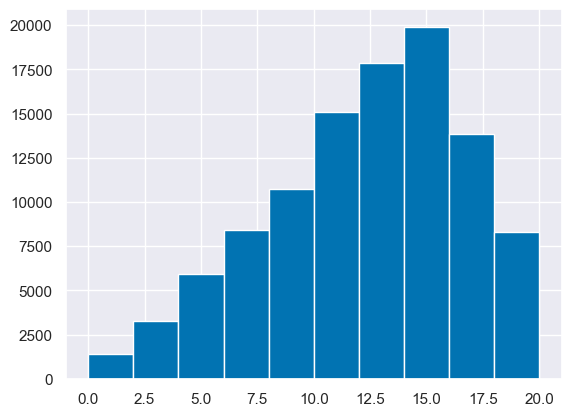

In [103]:
al_scale.hist();

In [132]:
al_scale.value_counts()

15.000000    4305
14.000000    3805
13.000000    3739
10.000000    3570
12.000000    3322
             ... 
15.514286       1
10.542857       1
8.159524        1
16.553571       1
15.104762       1
Length: 7728, dtype: int64

In [110]:
al_scale.isnull().sum()

6897

In [112]:
np.floor(al_scale.min())

0.0

0         False
1         False
2         False
3         False
4         False
          ...  
111616    False
111617     True
111618     True
111619    False
111620    False
Length: 111621, dtype: bool

In [114]:
al_scale_nulls = al_scale.isnull()
al_scale = al_scale.dropna()

0         16.250000
1          9.727273
2         13.553571
3         16.000000
4         12.000000
            ...    
111616    16.000000
111617          NaN
111618          NaN
111619     2.000000
111620    11.000000
Length: 111621, dtype: float64

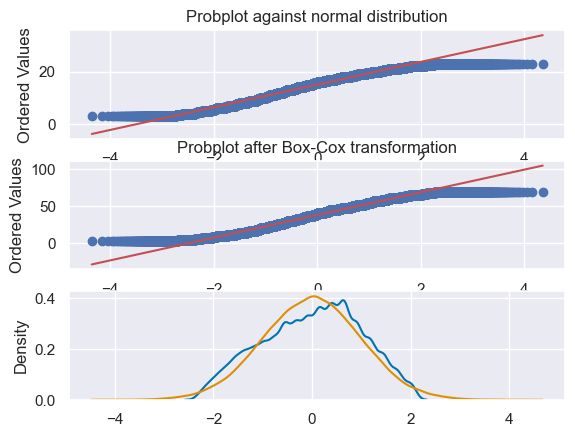

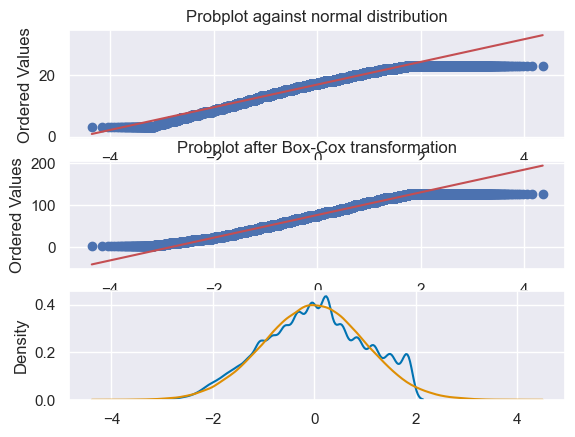

In [130]:
al_scale_bc = box_cox_normalise((al_scale))
lr_scale_bc = box_cox_normalise((lr_scale))

In [136]:
granularity = 20
lr_uniform = pd.qcut( -lr_scale_bc, q=granularity, labels=range(0,granularity))
al_uniform = pd.qcut( al_scale_bc, q=granularity, labels=range(0,granularity))


xlim = ( 0, granularity-1 )
ylim = ( 0, granularity-1 )

x_axis = "Economic: Left("+str(xlim[0])+") <-> Right("+str(xlim[1])+")"
y_axis = "Social: Liberalism("+str(ylim[0])+") <-> Conservatism("+str(ylim[1])+")"



In [144]:
(lr_uniform.value_counts(normalize=True).sort_index()-1/20).apply(lambda x : x*x).sum()

0.004818082004621578

In [150]:
pd.crosstab(lr_uniform, al_uniform,normalize='all').stack().apply(lambda x: (x-(1/400))**2).sum()

0.0009353416299821534

In [172]:
pd.crosstab(lr_uniform, al_uniform)-(total/400)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
row_0,,,,,,,,,,,,,,,,,,,,
0,851.75,173.75,193.75,12.75,-35.25,-33.25,-175.25,-96.25,-68.25,-168.25,-99.25,-6.25,-236.25,-4.25,-226.25,25.75,-168.25,-36.25,108.75,379.75
1,439.75,124.75,130.75,-19.25,-34.25,-40.25,-150.25,-101.25,-92.25,-152.25,-144.25,-29.25,-210.25,-16.25,-213.25,6.75,-138.25,-28.25,45.75,158.75
2,462.75,208.75,198.75,63.75,29.75,65.75,-107.25,-43.25,-12.25,-134.25,-75.25,45.75,-201.25,75.75,-186.25,63.75,-56.25,69.75,154.75,228.75
3,97.75,86.75,34.75,-18.25,-17.25,-41.25,-85.25,-116.25,-113.25,-100.25,-158.25,-34.25,-179.25,-44.25,-180.25,-10.25,-11.25,-14.25,73.75,48.75
4,188.75,83.75,152.75,0.75,35.75,0.75,-120.25,-71.25,-23.25,-117.25,-83.25,91.75,-197.25,80.75,-177.25,87.75,-70.25,49.75,49.75,53.75
5,255.75,156.75,286.75,128.75,123.75,156.75,-51.25,3.75,72.75,-56.25,22.75,254.75,-160.25,224.75,-156.25,236.75,3.75,155.75,155.75,137.75
6,-97.25,-39.25,-42.25,-74.25,-51.25,-61.25,-129.25,-130.25,-91.25,-75.25,-152.25,33.75,-175.25,-6.25,-166.25,-38.25,-113.25,-77.25,-51.25,-97.25
7,148.75,126.75,341.75,156.75,173.75,199.75,-53.25,160.75,226.75,-6.25,228.75,409.75,-144.25,645.75,-138.25,316.75,-16.25,107.75,122.75,58.75
8,-228.25,-177.25,-183.25,-190.25,-172.25,-164.25,-184.25,-191.25,-194.25,-161.25,-194.25,-99.25,-205.25,-106.25,-204.25,-144.25,-152.25,-159.25,-162.25,-180.25


In [170]:
round(pd.crosstab(lr_uniform, al_uniform,normalize='all').apply(lambda x: (x-(1/400))**2)*100000)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
row_0,,,,,,,,,,,,,,,,,,,,
0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
pd.crosstab(lr_uniform, al_uniform,normalize='all')*10000

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
row_0,,,,,,,,,,,,,,,,,,,,
0,108.097561,41.951220,43.902439,26.243902,21.560976,21.756098,7.902439,15.609756,18.341463,8.585366,15.317073,24.390244,1.951220,24.585366,2.926829,27.512195,8.585366,21.463415,35.609756,62.048780
1,67.902439,37.170732,37.756098,23.121951,21.658537,21.073171,10.341463,15.121951,16.000000,10.146341,10.926829,22.146341,4.487805,23.414634,4.195122,25.658537,11.512195,22.243902,29.463415,40.487805
2,70.146341,45.365854,44.390244,31.219512,27.902439,31.414634,14.536585,20.780488,23.804878,11.902439,17.658537,29.463415,5.365854,32.390244,6.829268,31.219512,19.512195,31.804878,40.097561,47.317073
3,34.536585,33.463415,28.390244,23.219512,23.317073,20.975610,16.682927,13.658537,13.951220,15.219512,9.560976,21.658537,7.512195,20.682927,7.414634,24.000000,23.902439,23.609756,32.195122,29.756098
4,43.414634,33.170732,39.902439,25.073171,28.487805,25.073171,13.268293,18.048780,22.731707,13.560976,16.878049,33.951220,5.756098,32.878049,7.707317,33.560976,18.146341,29.853659,29.853659,30.243902
5,49.951220,40.292683,52.975610,37.560976,37.073171,40.292683,20.000000,25.365854,32.097561,19.512195,27.219512,49.853659,9.365854,46.926829,9.756098,48.097561,25.365854,40.195122,40.195122,38.439024
6,15.512195,21.170732,20.878049,17.756098,20.000000,19.024390,12.390244,12.292683,16.097561,17.658537,10.146341,28.292683,7.902439,24.390244,8.780488,21.268293,13.951220,17.463415,20.000000,15.512195
7,39.512195,37.365854,58.341463,40.292683,41.951220,44.487805,19.804878,40.682927,47.121951,24.390244,47.317073,64.975610,10.926829,88.000000,11.512195,55.902439,23.414634,35.512195,36.975610,30.731707
8,2.731707,7.707317,7.121951,6.439024,8.195122,8.975610,7.024390,6.341463,6.048780,9.268293,6.048780,15.317073,4.975610,14.634146,5.073171,10.926829,10.146341,9.463415,9.170732,7.414634


Wall time: 25.6 s


<AxesSubplot:>

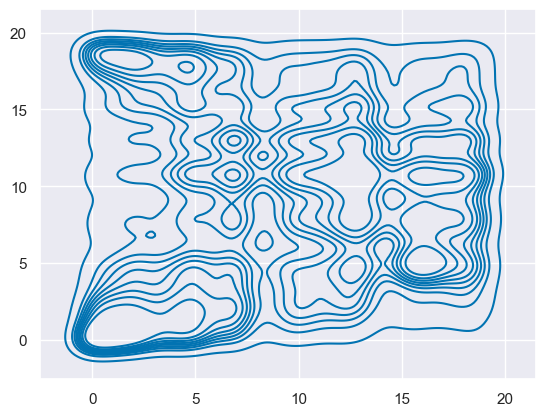

In [175]:
%%time
sns.kdeplot(x=lr_uniform.astype('float'),y=al_uniform.astype('float'));

Wall time: 26.1 s


<AxesSubplot:>

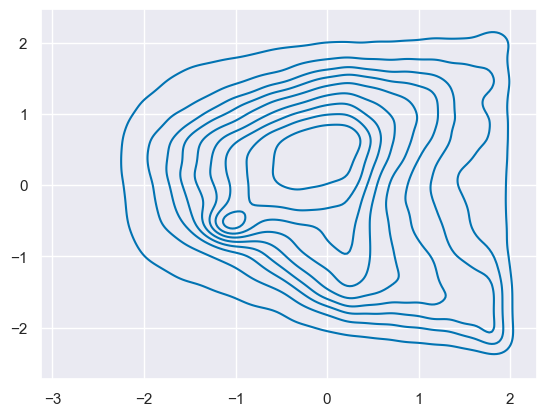

In [176]:
%%time
sns.kdeplot(x=lr_scale_bc.astype('float'),y=al_scale_bc.astype('float'));

<AxesSubplot:>

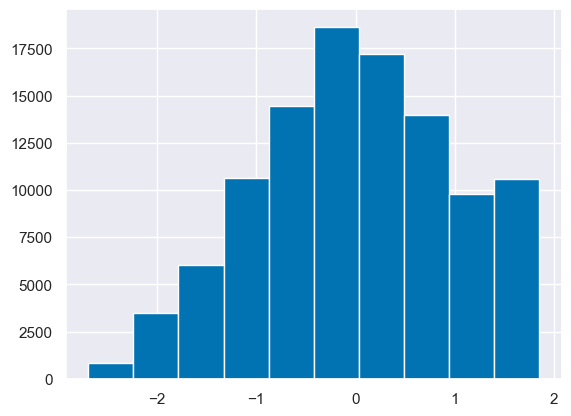

In [179]:
lr_scale_bc.hist()

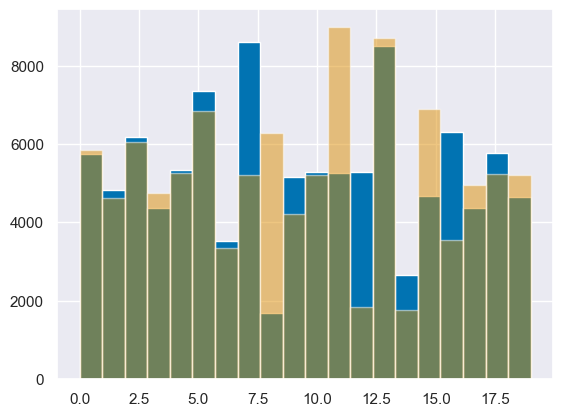

In [185]:
lr_uniform.hist(bins=20);
al_uniform.hist(bins=20,alpha=.5);

In [154]:
total = (lr_uniform.notnull()&al_uniform.notnull()).sum()


In [157]:
pd.crosstab(lr_uniform, al_uniform).stack().apply(lambda x: (x-(total/400))**2).sum()/(total)

95.87251707317073

In [159]:
al_uniform.corr(lr_uniform),al_scale_bc.corr(lr_scale_bc)

(0.07736227468018862, -0.0954449197270211)

In [160]:
al_uniform.corr(lr_uniform)**2

0.005984921543692953

In [226]:
def get_scales(inputs, manual=False):
    al1_wt = inputs[0]
    al2_wt = inputs[1]
    al3_wt = inputs[2]
    al4_wt = inputs[3]
    al5_wt = inputs[4]
    
    lr1_wt = inputs[5]
    lr2_wt = inputs[6]
    lr3_wt = inputs[7]
    lr4_wt = inputs[8]
    lr5_wt = inputs[9]
    
    al_scale = al1*al1_wt+al2*al2_wt+al3*al3_wt+al4*al4_wt+al5*al5_wt
    lr_scale = lr1*lr1_wt+lr2*lr2_wt+lr3*lr3_wt+lr4*lr4_wt+lr5*lr5_wt
    
    al_scale_bc = box_cox_normalise(al_scale,plot_figures=False)
    lr_scale_bc = box_cox_normalise(lr_scale,plot_figures=False)
    
    granularity = 20
    lr_uniform = pd.qcut( -lr_scale_bc, q=granularity, labels=range(0,granularity))
    al_uniform = pd.qcut( al_scale_bc, q=granularity, labels=range(0,granularity))
    
    total = (lr_uniform.notnull()&al_uniform.notnull()).sum()
    # 2d dist non-uniformity
    cost_fn = pd.crosstab(lr_uniform, al_uniform,normalize='all').stack().apply(lambda x: (x-(1/400))**2).sum()
    # need to add costs on input variables!
    cost_fn = cost_fn +\
        al_uniform.corr(lr_uniform)/10
    
#         + (np.sum([(inputs[x]-1)**2 for x in range(len(inputs))])/100000000)\    
    print(inputs,cost_fn,al_uniform.corr(lr_uniform))
    if not manual:
        return cost_fn
    else:     
        return cost_fn, al_uniform, lr_uniform, al_scale_bc, lr_scale_bc, al_scale, lr_scale

In [227]:
from scipy.optimize import minimize
x0 = [1.0,1.0,1.0,1.0,1.0, 1.0,1.0,1.0,1.0,1.0,]
solution = minimize(get_scales, x0, )

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 0.008671569098001016 0.07736227468018862
[1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ] 0.008500626641686854 0.0784091980052088
[1.         1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.        ] 0.008629295401609774 0.08015565764489013
[1.         1.         1.00000001 1.         1.         1.
 1.         1.         1.         1.        ] 0.00857581623381374 0.07906693663914868
[1.         1.         1.         1.00000001 1.         1.
 1.         1.         1.         1.        ] 0.008455947519241737 0.07845077132567138
[1.         1.         1.         1.         1.00000001 1.
 1.         1.         1.         1.        ] 0.008405838944537095 0.0776009274584584
[1.         1.         1.         1.         1.         1.00000001
 1.         1.         1.         1.        ] 0.00864792567787602 0.0794235585039238
[1.         1.         1.         1.         1. 

[1.00273663 1.00067676 1.00153292 1.0034519  1.0042541  1.00037851
 1.00343375 1.00320011 1.00487058 1.00831181] 0.007907052396934684 0.07518537274983465
[1.00273665 1.00067676 1.00153292 1.0034519  1.0042541  1.00037851
 1.00343375 1.00320011 1.00487058 1.00831181] 0.007907052396934684 0.07518537274983465
[1.00273663 1.00067678 1.00153292 1.0034519  1.0042541  1.00037851
 1.00343375 1.00320011 1.00487058 1.00831181] 0.007907052396934684 0.07518537274983465
[1.00273663 1.00067676 1.00153293 1.0034519  1.0042541  1.00037851
 1.00343375 1.00320011 1.00487058 1.00831181] 0.007907052396934684 0.07518537274983465
[1.00273663 1.00067676 1.00153292 1.00345192 1.0042541  1.00037851
 1.00343375 1.00320011 1.00487058 1.00831181] 0.007907052396934684 0.07518537274983465
[1.00273663 1.00067676 1.00153292 1.0034519  1.00425411 1.00037851
 1.00343375 1.00320011 1.00487058 1.00831181] 0.007907052396934684 0.07518537274983465
[1.00273663 1.00067676 1.00153292 1.0034519  1.0042541  1.00037852
 1.003433

[1.00001126 1.00000278 1.00000631 1.0000142  1.0000175  1.00000156
 1.00001412 1.00001316 1.00002003 1.00003419] 0.007907693336307932 0.07519069136426908
[1.00001127 1.00000278 1.00000631 1.0000142  1.0000175  1.00000156
 1.00001412 1.00001316 1.00002003 1.00003419] 0.007907693336307932 0.07519069136426908
[1.00001126 1.0000028  1.00000631 1.0000142  1.0000175  1.00000156
 1.00001412 1.00001316 1.00002003 1.00003419] 0.007907915908981517 0.07519284284948202
[1.00001126 1.00000278 1.00000632 1.0000142  1.0000175  1.00000156
 1.00001412 1.00001316 1.00002003 1.00003419] 0.007907699893101855 0.07519045806248792
[1.00001126 1.00000278 1.00000631 1.00001421 1.0000175  1.00000156
 1.00001412 1.00001316 1.00002003 1.00003419] 0.0079077161275413 0.07519055949076102
[1.00001126 1.00000278 1.00000631 1.0000142  1.00001751 1.00000156
 1.00001412 1.00001316 1.00002003 1.00003419] 0.007907815749618637 0.07519161853128452
[1.00001126 1.00000278 1.00000631 1.0000142  1.0000175  1.00000157
 1.00001412

[1.00001129 1.00000217 1.00000631 1.00001418 1.00001721 1.00000156
 1.00001417 1.00001321 1.0000201  1.0000343 ] 0.007909621218569278 0.07521005775380699
[1.00001131 1.00000217 1.00000631 1.00001418 1.00001721 1.00000156
 1.00001417 1.00001321 1.0000201  1.0000343 ] 0.00790926251812826 0.07520653547277575
[1.00001129 1.00000218 1.00000631 1.00001418 1.00001721 1.00000156
 1.00001417 1.00001321 1.0000201  1.0000343 ] 0.00790955518723172 0.07520946216381036
[1.00001129 1.00000217 1.00000632 1.00001418 1.00001721 1.00000156
 1.00001417 1.00001321 1.0000201  1.0000343 ] 0.007909232254267911 0.07520626329223296
[1.00001129 1.00000217 1.00000631 1.0000142  1.00001721 1.00000156
 1.00001417 1.00001321 1.0000201  1.0000343 ] 0.007909429010995336 0.07520832223368923
[1.00001129 1.00000217 1.00000631 1.00001418 1.00001723 1.00000156
 1.00001417 1.00001321 1.0000201  1.0000343 ] 0.007909165842548967 0.07520562963310419
[1.00001129 1.00000217 1.00000631 1.00001418 1.00001721 1.00000158
 1.00001417

[1.00001129 1.00000255 1.00000631 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007906726904355394 0.0751818817740715
[1.00001127 1.00000257 1.00000631 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007906875478519013 0.07518331802135908
[1.00001127 1.00000255 1.00000632 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007907147500675631 0.07518596209777356
[1.00001127 1.00000255 1.00000631 1.00001421 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007907109640497017 0.07518568629194221
[1.00001127 1.00000255 1.00000631 1.00001419 1.00001741 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007907413247280096 0.07518866715453802
[1.00001127 1.00000255 1.00000631 1.00001419 1.00001739 1.00000157
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007907109640497017 0.07518568629194221
[1.00001127 1.00000255 1.00000631 1.00001419 1.00001739 1.00000156
 1.0000141

[1.00001127 1.00000255 1.00000631 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007907109640497017 0.07518568629194221
[1.00001129 1.00000255 1.00000631 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007906726904355394 0.0751818817740715
[1.00001127 1.00000257 1.00000631 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007906875478519013 0.07518331802135908
[1.00001127 1.00000255 1.00000632 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007907147500675631 0.07518596209777356
[1.00001127 1.00000255 1.00000631 1.00001421 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007907109640497017 0.07518568629194221
[1.00001127 1.00000255 1.00000631 1.00001419 1.00001741 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007907413247280096 0.07518866715453802
[1.00001127 1.00000255 1.00000631 1.00001419 1.00001739 1.00000157
 1.0000141

[1.00001127 1.00000255 1.00000631 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003425] 0.007907109640497017 0.07518568629194221
[1.00001127 1.00000255 1.00000631 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007907109640497017 0.07518568629194221
[1.00001129 1.00000255 1.00000631 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007906726904355394 0.0751818817740715
[1.00001127 1.00000257 1.00000631 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007906875478519013 0.07518331802135908
[1.00001127 1.00000255 1.00000632 1.00001419 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007907147500675631 0.07518596209777356
[1.00001127 1.00000255 1.00000631 1.00001421 1.00001739 1.00000156
 1.00001414 1.00001318 1.00002006 1.00003423] 0.007907109640497017 0.07518568629194221
[1.00001127 1.00000255 1.00000631 1.00001419 1.00001741 1.00000156
 1.0000141

In [215]:
cost_fn, al_uniform, lr_uniform, al_scale_bc, lr_scale_bc, al_scale, lr_scale = get_scales(x0,manual=True)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 0.0009353416299821534 0.07736227468018862


In [209]:
# looks like function has automatic regularisation and it's a bit too strong!

0.0009353416299821534

In [229]:
x1 = [1.2217999,  1.05485063, 1.1242405,  1.2797716,  1.34478809, 1.03067762,
 1.27829994, 1.25936401, 1.39475325, 1.67365997]

In [230]:
cost_fn, al_uniform, lr_uniform, al_scale_bc, lr_scale_bc, al_scale, lr_scale = get_scales(x1,manual=True)

[1.2217999, 1.05485063, 1.1242405, 1.2797716, 1.34478809, 1.03067762, 1.27829994, 1.25936401, 1.39475325, 1.67365997] 0.006256345979802109 0.05885382124953805


Wall time: 25.6 s


<AxesSubplot:>

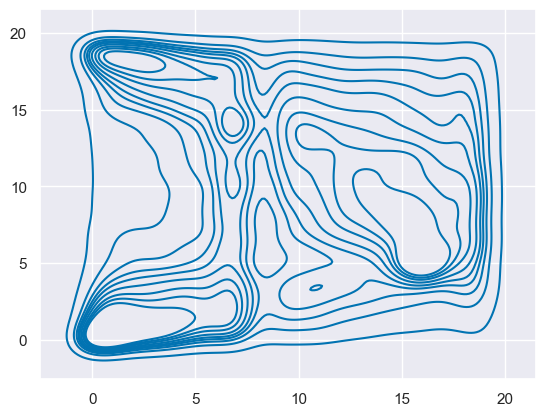

In [231]:
%%time
sns.kdeplot(x=lr_uniform.astype('float'),y=al_uniform.astype('float'));

Wall time: 26.1 s


<AxesSubplot:>

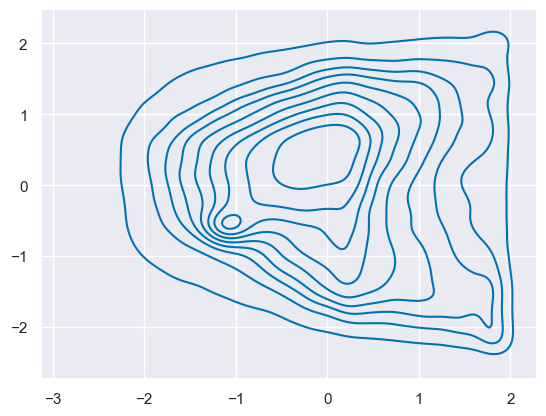

In [232]:
%%time
sns.kdeplot(x=lr_scale_bc.astype('float'),y=al_scale_bc.astype('float'));

In [ ]:
# not happy with how much structure remains!

# how about use sparse PCA factor extraction method *with averages per variable*? (no missing values, no imputation)


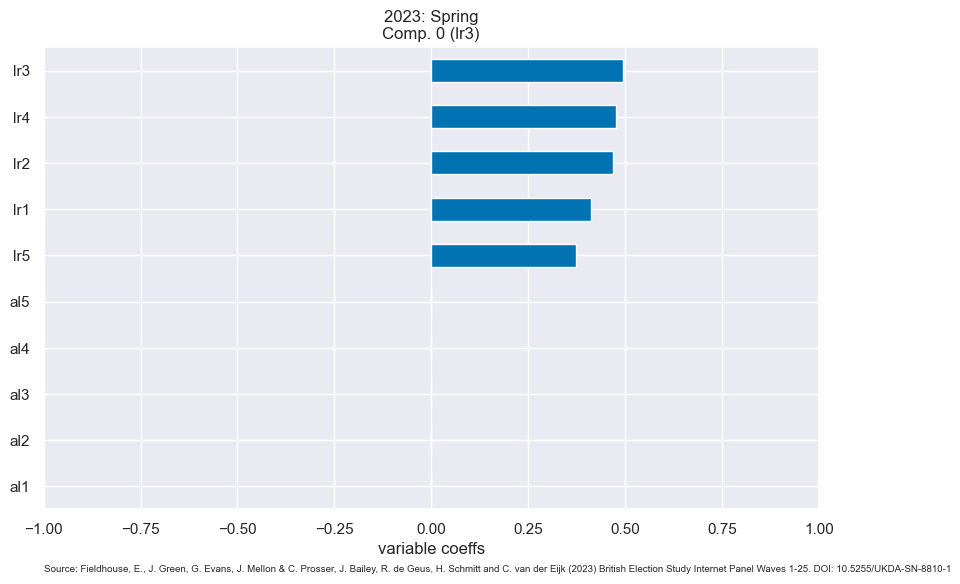

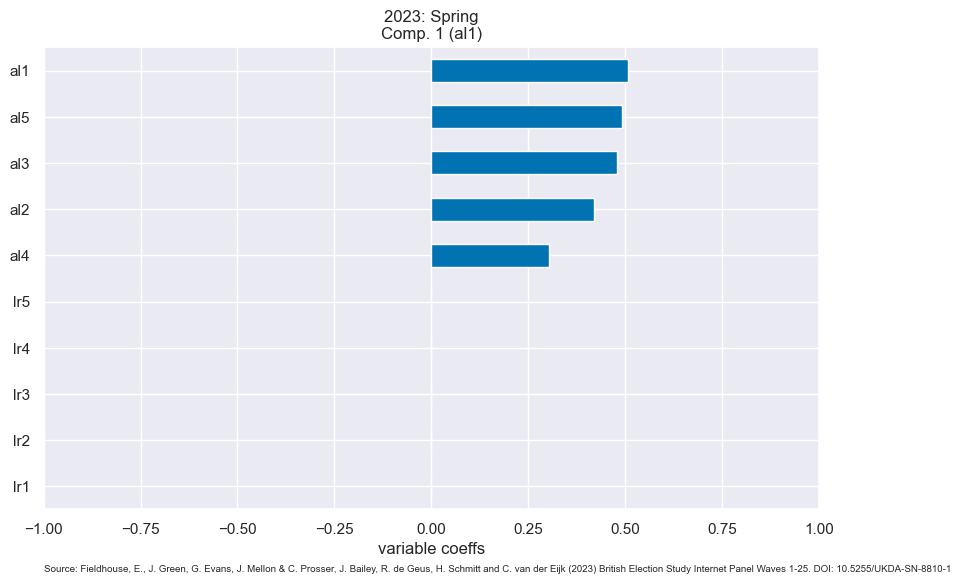

In [239]:
Treatment = "pan-dataset-values" + "_allr_values" + "_no_imp"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )
    
BES_vals = pd.concat([ al1,al2,al3,al4,al5,lr1,lr2,lr3,lr4,lr5
                       ],axis=1)
BES_vals.columns = ["al1","al2","al3","al4","al5","lr1","lr2","lr3","lr4","lr5",]
BES_vals.isnull().any(axis=1).sum()
# 2665
pres_mask = BES_vals.notnull().all(axis=1)    

(BES_decomp, comp_labels, comp_dict) = extra_sparse_factors(BES_vals[pres_mask], Treatment, alpha=94,max_var_per_comp=40)

<AxesSubplot:>

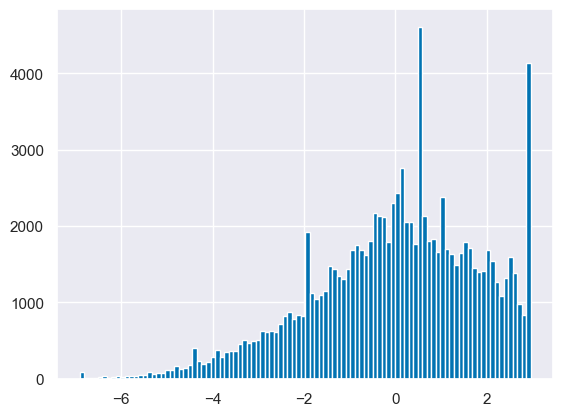

In [242]:
BES_decomp["Comp. 0 (lr3)"].hist(bins=100)

0         1.552089
1        -1.305952
2         0.120124
3        -0.370854
4        -1.398200
            ...   
111614   -0.054777
111615    1.206745
111616    1.125908
111619    1.839181
111620    0.877456
Length: 102500, dtype: float64

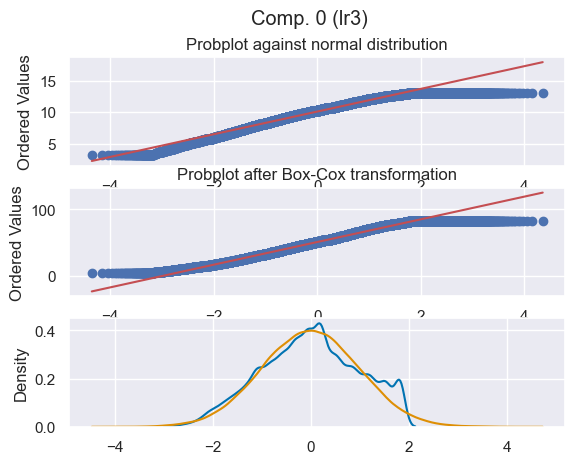

In [252]:
box_cox_normalise(BES_decomp["Comp. 0 (lr3)"]-np.floor(BES_decomp[comp_labels[0]].min()))

In [253]:
BES_decomp.corr()

,Comp. 0 (lr3),Comp. 1 (al1)
Comp. 0 (lr3),1.0000,-0.1101
Comp. 1 (al1),-0.1101,1.0000


In [249]:
## worse raw correlation!

-7.0

In [ ]:
## well, whatever the output/s, the next stage is

# fill in the gaps with some *adequate* xgboost prediction, save for each column under <blah>_complete

# save pan_datasset values

In [257]:
BES_decomp[BES_decomp.columns[0]]

0         2.568211
1        -2.414901
2         0.368672
3        -0.499216
4        -2.630110
            ...   
111614    0.067899
111615    2.073735
111616    1.955098
111619    2.965212
111620    1.583024
Name: Comp. 0 (lr3), Length: 102500, dtype: float64

In [255]:
BES_reduced_with_na.dtypes.value_counts()

float64    13180
dtype: int64

In [259]:
BES_reduced_with_na["harm_values_lr"] = BES_decomp[BES_decomp.columns[0]]

In [260]:
BES_reduced_with_na["harm_values_lr"]

0         2.568211
1        -2.414901
2         0.368672
3        -0.499216
4        -2.630110
            ...   
111616    1.955098
111617         NaN
111618         NaN
111619    2.965212
111620    1.583024
Name: harm_values_lr, Length: 111621, dtype: float64

In [273]:
lr_corrs

turnoutUKGeneralW1__Very likely that I will vote   -0.033659
turnoutUKGeneralW2__Very likely that I will vote   -0.013443
turnoutUKGeneralW3__Very likely that I will vote   -0.022189
turnoutUKGeneralW4__Very likely that I will vote   -0.010395
turnoutUKGeneralW5__Very likely that I will vote   -0.018680
                                                      ...   
labPriorities2_econW4_Yes                           0.192734
ukipPriorities2_schoolW4_Yes                       -0.050048
ukipPriorities2_natsecW4_Yes                       -0.072123
ukipPriorities2_crimeW4_Yes                        -0.051490
ukipPriorities2_noneW4_Yes                          0.073577
Length: 13180, dtype: float64

In [284]:
lr_predictors

['harm_values_lr']

In [20]:
def complete_values_column(Treatment,var1,exclude_vars,frac_keep=.1):

    # lr_pan_data_col = pan_dataset_allr_values.columns[2]
    # BES_reduced_with_na[var1]= pan_dataset_allr_values[ lr_pan_data_col ]

    temp_mask = BES_reduced_with_na[var1].notnull()

    # variable populatied less than 10% of the time for missing values
    
    var_nulls = BES_reduced_with_na[var1].isnull()
    low_freq_vars = list(BES_reduced_with_na.columns[BES_reduced_with_na.notnull().loc[var_nulls].sum()<(var_nulls.sum()*frac_keep)])
    
#     low_freq_vars = list(BES_reduced_with_na.columns[BES_reduced_with_na[BES_reduced_with_na[var1].isnull()].notnull().sum()<(BES_reduced_with_na[var1].isnull().sum()*frac_keep)])


    lr_predictors = [x for x in lr_corrs.abs().dropna().sort_values(ascending=False).head(5000).index if (x not in exclude_vars)\
                         and (x not in low_freq_vars)]
    lr_predictors.append(var1)
    # df = BES_reduced_with_na[lr_predictors][temp_mask]

    var_stub = var1

    var_list = [var_stub]
    var_stub_list = [var_stub]

    ## 26s up to here
    # (explainer, shap_values, train_columns, alg) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
    #            title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
    # treatment_dict[Treatment] = shap_array(shap_values, train_columns, threshold = .1, min_features = 50)

    (explainer, shap_values, train_columns, train_index, alg,output_subfolder,metrics) = xgboost_run(
        title = "How many years ago did you first start your relationship with your partner?",
        dataset=BES_reduced_with_na.loc[temp_mask,lr_predictors],
                                                        var_list = var_list,var_stub_list =var_stub_list,verbosity=0)
    lr_train_columns = train_columns
    lr_alg = alg
    # mask = pan_dataset_allr_values[ lr_pan_data_col ].isnull()
    mask = BES_reduced_with_na[var1].isnull()
    # 
    lr_pred = lr_alg.predict(BES_reduced_with_na.loc[mask,lr_train_columns])
    return lr_pred

MSE: 1.78, MAE: 1.03, EV: 0.47, R2: 0.47


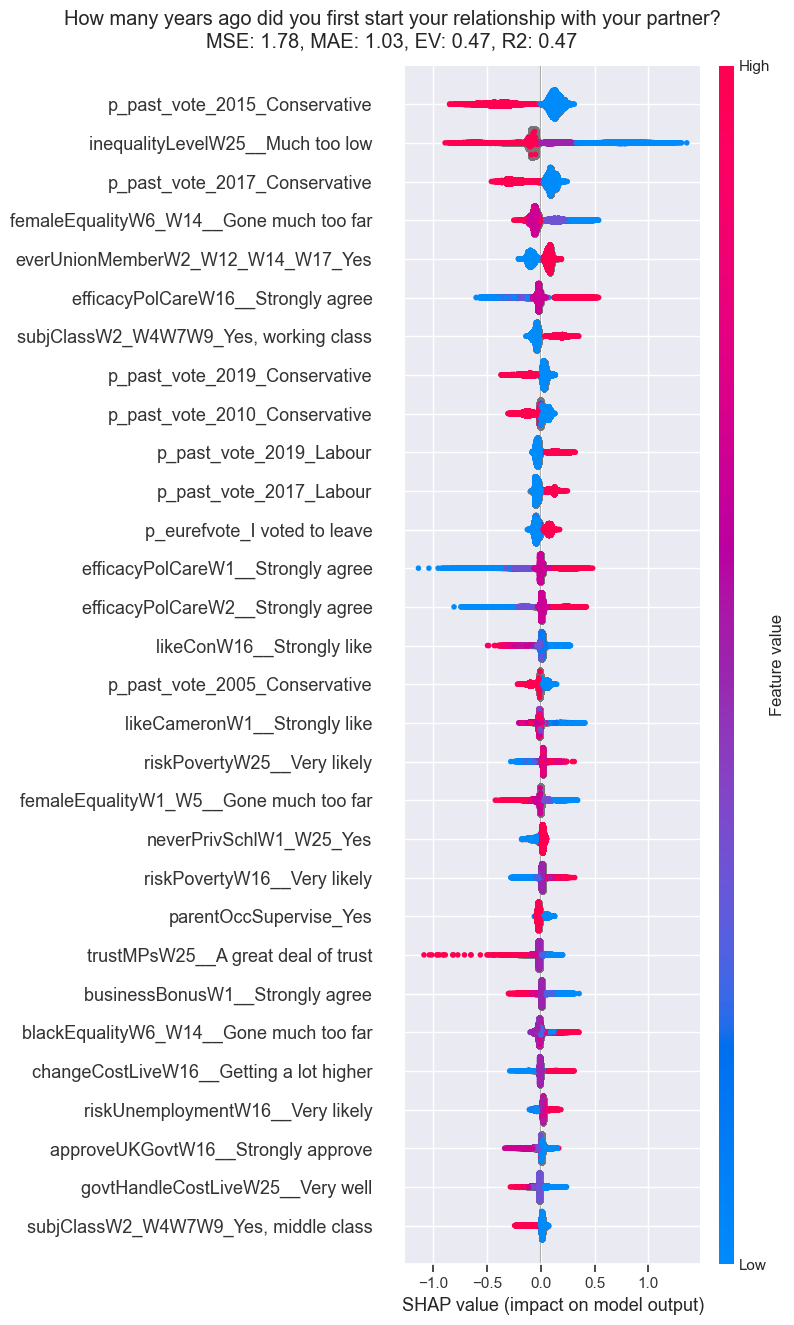

Wall time: 1min 59s


In [290]:
%%time
BES_reduced_with_na["harm_values_lr"] = BES_decomp[BES_decomp.columns[0]]
Treatment = "predicted_lr_values"
var1 = "harm_values_lr"
exclude_vars = list( match(BES_reduced_with_na,"(lr|al)_scale|(lr|al)\d").index )

imputed_vals = complete_values_column(Treatment,var1,exclude_vars,frac_keep=.1)
BES_reduced_with_na.drop("harm_values_lr",axis=1,inplace=True)

In [ ]:
## run through varioable sets

### raw averaged data -> fill gaps (round - no - already contains floats from averaging), (already discrete - nope, averaging!)
### raw data uniform -> fill gaps (round- no - already contains floats from averaging), (already discrete - nope, averaging!)
### flattened data -> continuous, fill gaps, discrete

# save version with no gaps
# save version quantised (different granularities?)

In [19]:
# del BES_reduced_with_na[var1]

MSE: 8.60, MAE: 2.29, EV: 0.38, R2: 0.38


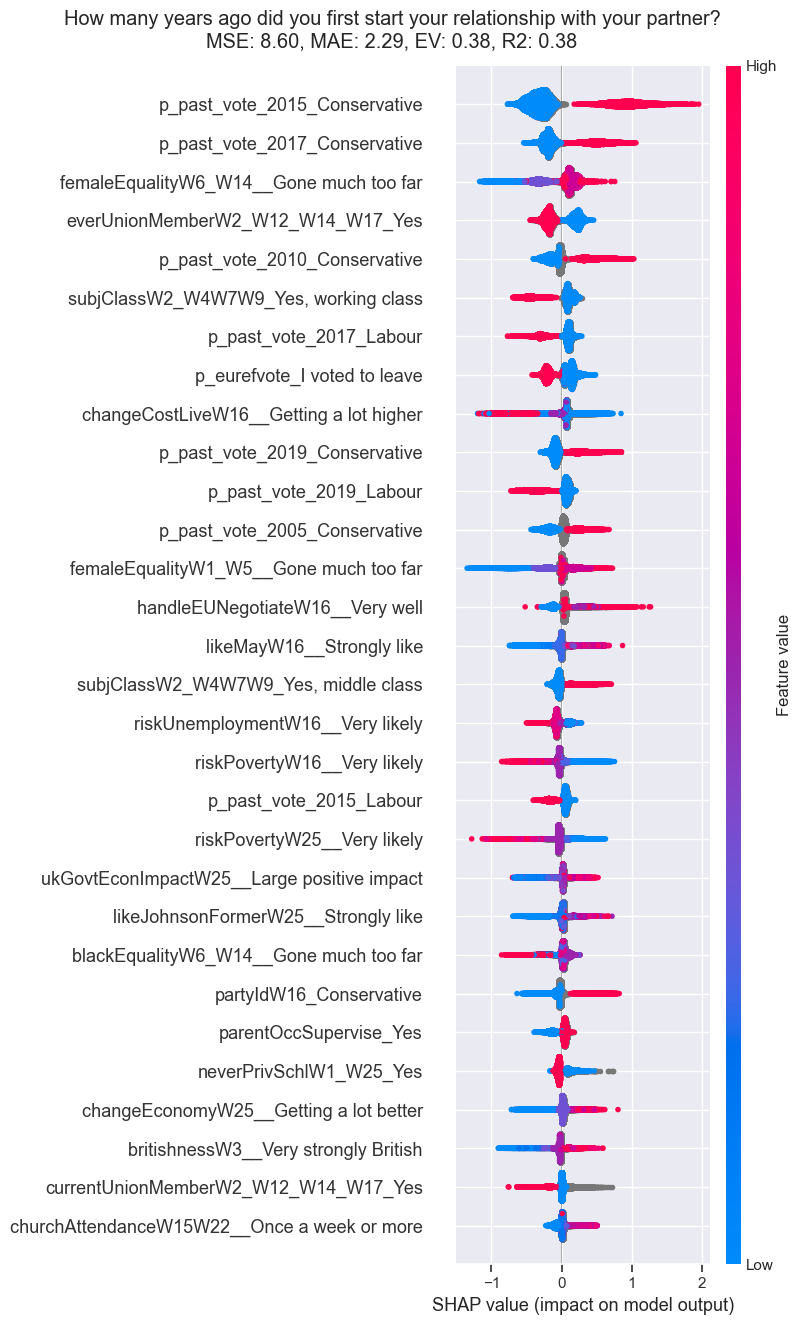

MSE: 9.46, MAE: 2.41, EV: 0.51, R2: 0.51


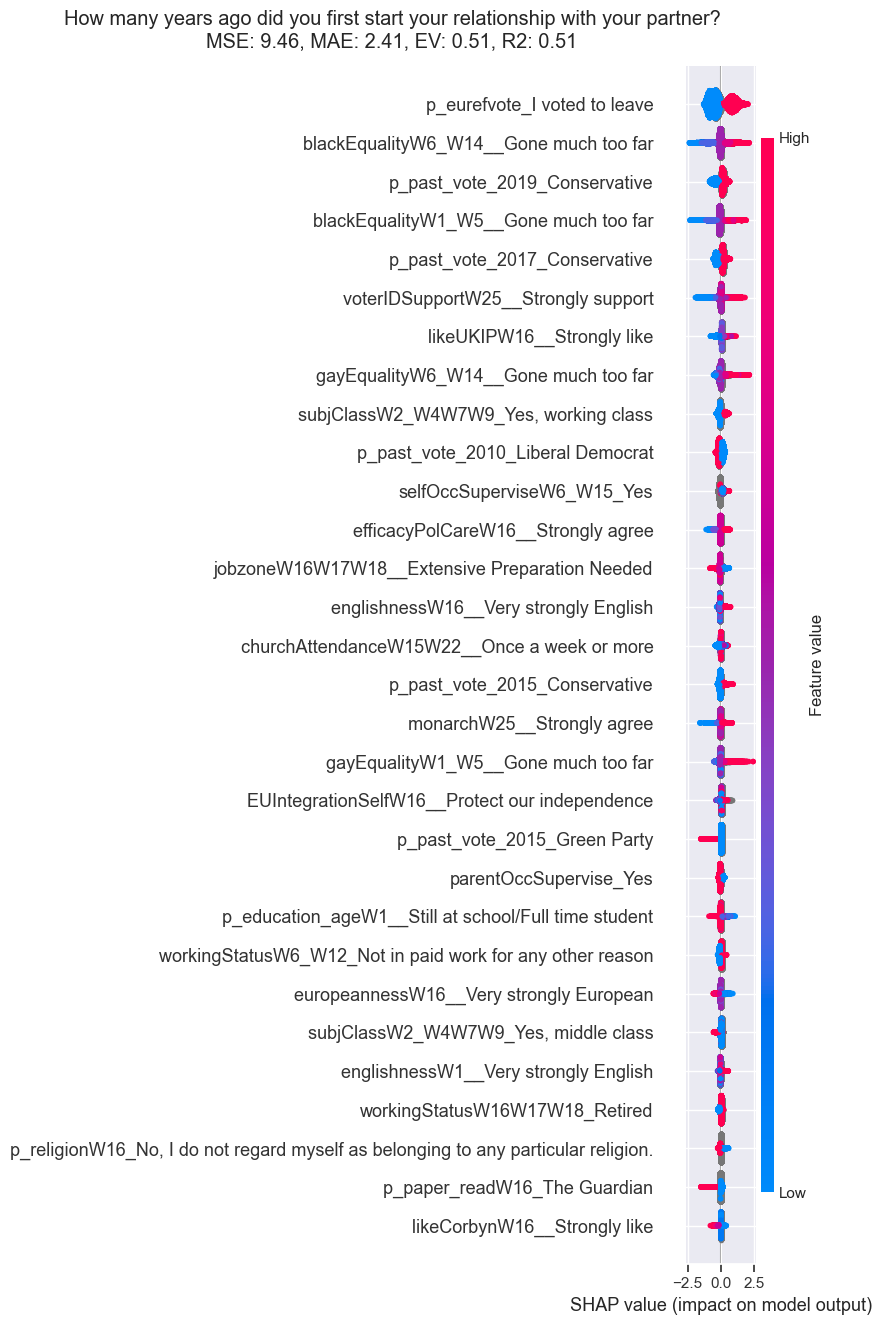

In [21]:
pan_dataset_allr_valuesW25 = pd.DataFrame()

pan_dataset_allr_valuesW25["al_scale_raw"] = al_scale_raw
pan_dataset_allr_valuesW25["lr_scale_raw"] = lr_scale_raw

pan_dataset_allr_valuesW25["lr_scale_raw_complete"] = lr_scale_raw
pan_dataset_allr_valuesW25["al_scale_raw_complete"] = al_scale_raw

var1 = "lr_scale_raw_complete"
BES_reduced_with_na[var1] = pan_dataset_allr_valuesW25[var1]
Treatment = var1
exclude_vars = match_eff(BES_reduced_with_na.columns,"(lr|al)_scale|(lr|al)\d")
imputed_vals = complete_values_column(Treatment,var1,exclude_vars,frac_keep=.1)
del BES_reduced_with_na[var1]
pan_dataset_allr_valuesW25.loc[pan_dataset_allr_valuesW25[var1].isnull(),var1] = imputed_vals

var1 = "al_scale_raw_complete"
BES_reduced_with_na[var1] = pan_dataset_allr_valuesW25[var1]
Treatment = var1
exclude_vars = match_eff(BES_reduced_with_na.columns,"(lr|al)_scale|(lr|al)\d")
imputed_vals = complete_values_column(Treatment,var1,exclude_vars,frac_keep=.1)
del BES_reduced_with_na[var1]
pan_dataset_allr_valuesW25.loc[pan_dataset_allr_valuesW25[var1].isnull(),var1] = imputed_vals

In [31]:
%debug

> e:\users\gamer\anaconda3\envs\test_tensorflow_install\lib\site-packages\pandas\core\indexing.py(1322)_validate_read_indexer()
   1320             with option_context("display.max_seq_items", 10, "display.width", 80):
   1321                 raise KeyError(
-> 1322                     "Passing list-likes to .loc or [] with any missing labels "
   1323                     "is no longer supported. "
   1324                     f"The following labels were missing: {not_found}. "

ipdb> up
> e:\users\gamer\anaconda3\envs\test_tensorflow_install\lib\site-packages\pandas\core\indexing.py(1266)_get_listlike_indexer()
   1264             keyarr, indexer, new_indexer = ax._reindex_non_unique(keyarr)
   1265 
-> 1266         self._validate_read_indexer(keyarr, indexer, axis, raise_missing=raise_missing)
   1267         return keyarr, indexer
   1268 

ipdb> up
> e:\users\gamer\anaconda3\envs\test_tensorflow_install\lib\site-packages\pandas\core\indexing.py(1053)_getitem_iterable()
   1051 
   1

In [30]:
# BES_reduced_with_na[lr_predictors][temp_mask]

In [316]:
low_freq_vars = list(BES_reduced_with_na.columns[BES_reduced_with_na[BES_reduced_with_na[var1].isnull()].notnull().sum()<(BES_reduced_with_na[var1].isnull().sum()*frac_keep)])

112

In [329]:
frac_keep=.1
var_nulls = BES_reduced_with_na[var1].isnull()
BES_reduced_with_na.columns[BES_reduced_with_na.notnull().loc[var_nulls].sum()<(var_nulls.sum()*frac_keep)]

Index(['turnoutUKGeneralW1__Very likely that I will vote',
       'turnoutUKGeneralW2__Very likely that I will vote',
       'turnoutUKGeneralW4__Very likely that I will vote',
       'turnoutUKGeneralW5__Very likely that I will vote',
       'turnoutUKGeneralW7__Very likely that I will vote',
       'turnoutUKGeneralW8__Very likely that I will vote',
       'turnoutUKGeneralW9__Very likely that I will vote',
       'turnoutUKGeneralW10__Very likely that I will vote',
       'turnoutUKGeneralW11__Very likely that I will vote',
       'turnoutUKGeneralW12__Very likely that I will vote',
       ...
       'responsibleEducationDontKnowW3_Yes', 'responsibleEducationNoneW3_Yes',
       'statusActivities2_18W25_Yes', 'euRefVoteAfterW23_Stay out of the EU',
       'labPriorities2_econW4_Yes', 'ukipPriorities2_schoolW4_Yes',
       'ukipPriorities2_natsecW4_Yes', 'ukipPriorities2_crimeW4_Yes',
       'ukipPriorities2_noneW4_Yes', 'lr_scale_raw_complete'],
      dtype='object', length=12363)

In [29]:
# BES_reduced_with_na.loc[var_nulls,:]#.notnull().sum()

turnoutUKGeneralW1__Very likely that I will vote    510
turnoutUKGeneralW2__Very likely that I will vote    545
turnoutUKGeneralW3__Very likely that I will vote    661
turnoutUKGeneralW4__Very likely that I will vote    451
turnoutUKGeneralW5__Very likely that I will vote    298
                                                   ... 
ukipPriorities2_schoolW4_Yes                         50
ukipPriorities2_natsecW4_Yes                        138
ukipPriorities2_crimeW4_Yes                          50
ukipPriorities2_noneW4_Yes                           50
lr_scale_raw_complete                                 0
Length: 13181, dtype: int64

In [23]:
match_eff(BES_reduced_with_na.columns,"(lr|al)_scale|(lr|al)\d")

['lr1W6__Strongly agree',
 'lr2W6__Strongly agree',
 'lr3W6__Strongly agree',
 'lr4W6__Strongly agree',
 'lr5W6__Strongly agree',
 'al1W6__Strongly agree',
 'al2W6__Strongly agree',
 'al3W6__Strongly agree',
 'al4W6__Strongly agree',
 'al5W6__Strongly agree',
 'lr1W13__Strongly agree',
 'lr2W13__Strongly agree',
 'lr3W13__Strongly agree',
 'lr4W13__Strongly agree',
 'lr5W13__Strongly agree',
 'al1W13__Strongly agree',
 'al2W13__Strongly agree',
 'al3W13__Strongly agree',
 'al4W13__Strongly agree',
 'al5W13__Strongly agree',
 'lr1W16__Strongly agree',
 'lr2W16__Strongly agree',
 'lr3W16__Strongly agree',
 'lr4W16__Strongly agree',
 'lr5W16__Strongly agree',
 'al1W16__Strongly agree',
 'al2W16__Strongly agree',
 'al3W16__Strongly agree',
 'al4W16__Strongly agree',
 'al5W16__Strongly agree',
 'lr1W20__Strongly agree',
 'lr2W20__Strongly agree',
 'lr3W20__Strongly agree',
 'lr4W20__Strongly agree',
 'lr5W20__Strongly agree',
 'al1W20__Strongly agree',
 'al2W20__Strongly agree',
 'al3W20__S

In [24]:
# BES_reduced_with_na.drop("lr_scale_raw_complete",axis=1,inplace=True)

In [311]:
gc.collect()

1714701

In [ ]:
# del BES_reduced_with_na["lr_scale_raw_complete"]

,turnoutUKGeneralW1__Very likely that I will vote,turnoutUKGeneralW2__Very likely that I will vote,turnoutUKGeneralW3__Very likely that I will vote,turnoutUKGeneralW4__Very likely that I will vote,turnoutUKGeneralW5__Very likely that I will vote,turnoutUKGeneralW7__Very likely that I will vote,turnoutUKGeneralW8__Very likely that I will vote,turnoutUKGeneralW9__Very likely that I will vote,turnoutUKGeneralW10__Very likely that I will vote,turnoutUKGeneralW11__Very likely that I will vote,...,responsibleEducationDontKnowW3_Yes,responsibleEducationNoneW3_Yes,hasValidVoteIDW25_Yes,statusActivities2_18W25_Yes,euRefVoteAfterW23_Stay out of the EU,labPriorities2_econW4_Yes,ukipPriorities2_schoolW4_Yes,ukipPriorities2_natsecW4_Yes,ukipPriorities2_crimeW4_Yes,ukipPriorities2_noneW4_Yes
0,4.0,4.0,NaN,4.0,4.0,4.0,4.0,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,...,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,3.0,1.0,...,0.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
len(search_eff(BES_reduced_with_na.columns,"Strongly agree"))

734

In [ ]:
acquiescence = BES_reduced_with_na[search_eff(BES_reduced_with_na.columns,"Strongly agree")].apply(lambda x: x/x.max()).mean(axis=1)

# we should normalise first!

In [ ]:
acquiescence.hist(bins=100)

In [ ]:
BES_reduced_with_na["acquiescence"] = acquiescence

In [ ]:
%%time
name = "acquiescence"

(explainer, shap_values, train_columns, train_index, alg,output_subfolder,metrics) = xgboost_run(
    title = "What is your crudely estimated level of acquiescence bias?",
    dataset=BES_reduced_with_na,
                                                    var_list = [name],var_stub_list = [name],verbosity=0)